# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?

In [1]:
# Your code here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (16,6)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

In [3]:
# importing data 
data = pd.read_csv('data.csv')

##  Exploratory Data Analysis

In [4]:
# The dataset contains over 600K rows and 11 columns
data.shape

(6362620, 11)

In [5]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [6]:
# The dataset includes 8 numerical columns, 2 columns related to identification of subjects and 1 categorical
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [7]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [8]:
round(data.describe())

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0
mean,243.0,179862.0,833883.0,855114.0,1100702.0,1224996.0,0.0,0.0
std,142.0,603858.0,2888243.0,2924049.0,3399180.0,3674129.0,0.0,0.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,156.0,13390.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,239.0,74872.0,14208.0,0.0,132706.0,214661.0,0.0,0.0
75%,335.0,208721.0,107315.0,144258.0,943037.0,1111909.0,0.0,0.0
max,743.0,92445517.0,59585040.0,49585040.0,356015889.0,356179279.0,1.0,1.0


In [9]:
# There are no missing values in the dataset
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

(8.5, -0.5)

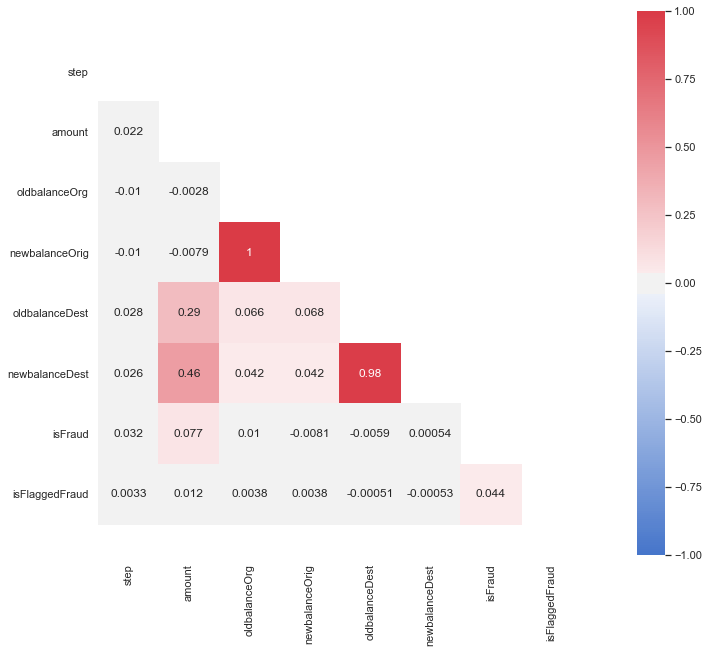

In [10]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(20,10))

# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors

# Plot the heatmap
sns.heatmap(data.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1, ax=ax)  

# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

In [11]:
# There are strong correlations between oldbalanceOrg/newbalanceOrig and oldbalanceDest/newbalanceDest since these
# columns relate to the balances in the same bank accounts before and after each transaction

# newbalanceDest and amount are strongly correlated (almost 0.50)

### What is the distribution of the outcome? 

In [12]:
# By checking how many transactions out of the >600k records are fraud, we notice there are less than 1% of casesdata.isFraud.value_counts()

In [13]:
# Calculating distribution of the outcome it's clear that alsmot 99.9% of the trasactions are not Fraud
(data.isFraud.value_counts()/len(data))*100

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

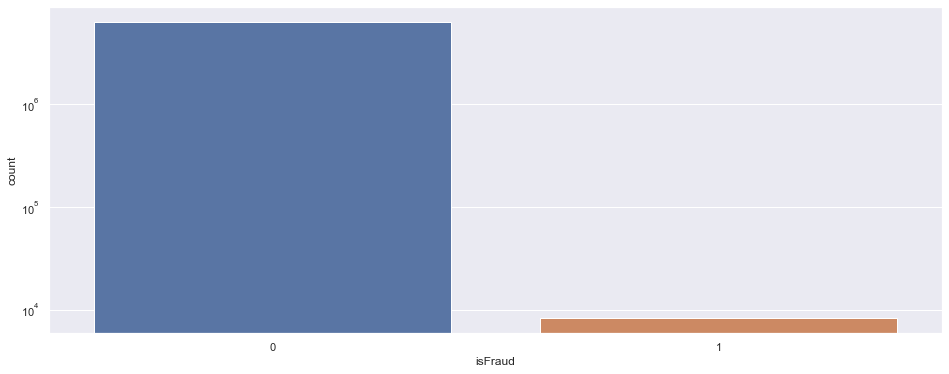

In [14]:
# Plotting the distribution of the outcome
sns.set(style="darkgrid")

ax = sns.countplot(x=data["isFraud"], data=data)
ax.set_yscale("log")

In [15]:
# Very little cases from the 8213 frauds are flagged as such (<1%)
data.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [16]:
# There seems to be a rather large number of cases that go  by unnoticed 
cases_unflagged = round((len(data.loc[data.isFraud==1])-len(data.loc[data.isFlaggedFraud==1]))/len(data)*100,2)
print(f'Percentage of FRAUD detected from total cases: {cases_unflagged}%')

Percentage of FRAUD detected from total cases: 0.13%


In [17]:
data['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

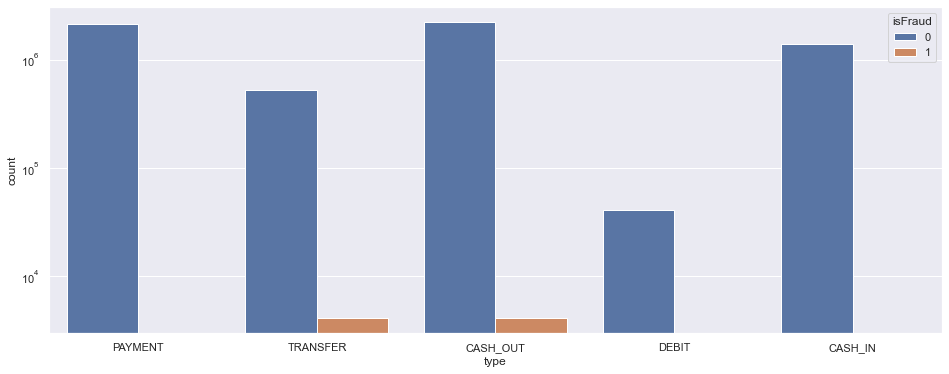

In [18]:
# Looking at the transaction types, it is clear that the cases of fraud happen in transfers and cash-out
sns.set(style="darkgrid")

ax = sns.countplot(x=data["type"], hue="isFraud", data=data)
ax.set_yscale("log")

In [19]:
# The only cases of fraud are found in CASH_OUT and TRANSFER
data['type'].loc[data.isFraud == 1].value_counts()

CASH_OUT    4116
TRANSFER    4097
Name: type, dtype: int64

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

In [20]:
data['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [21]:
data['step'].nunique()

743

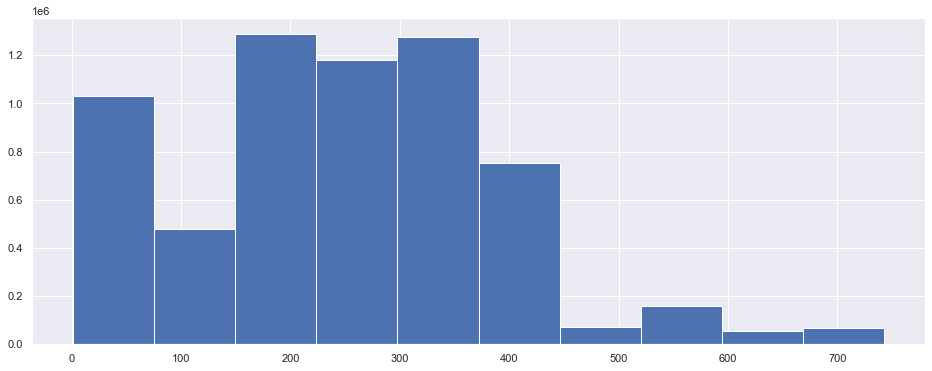

In [22]:
# It's not clear what the variable STEP represents given it's wide range of values and nature
data['step'].hist()

In [23]:
# We'll assume it's related with TIME and keep the module of the step column
data['hour'] = data['step']%24

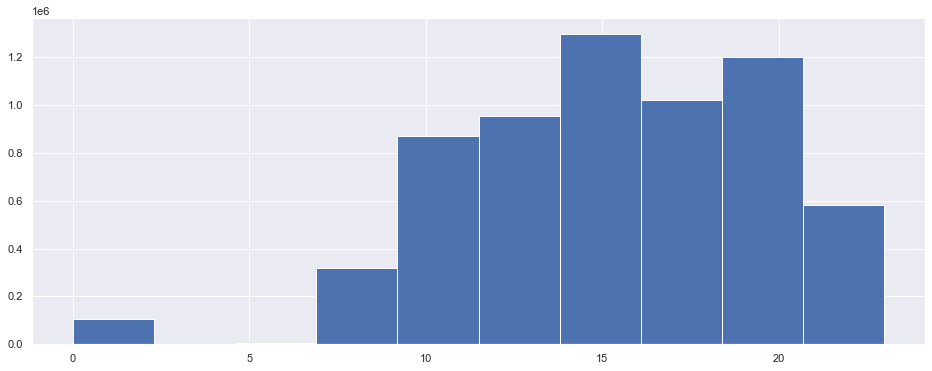

In [24]:
data['hour'].hist()

In [25]:
# Given the strong correlation of these columns and the lack of numerical data, we'll drop the unecessary columns

data.drop(columns = ['oldbalanceOrg','oldbalanceDest','nameOrig','nameDest','step'], inplace = True)

In [26]:
# Next step is to OneHot Encode the column TYPE and turn its data into numerical 
data = pd.get_dummies(data, columns = ['type'])

In [27]:
data.head()

,amount,newbalanceOrig,newbalanceDest,isFraud,isFlaggedFraud,hour,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,9839.64,160296.36,0.0,0,0,1,0,0,0,1,0
1,1864.28,19384.72,0.0,0,0,1,0,0,0,1,0
2,181.00,0.00,0.0,1,0,1,0,0,0,0,1
3,181.00,0.00,0.0,1,0,1,0,1,0,0,0
4,11668.14,29885.86,0.0,0,0,1,0,0,0,1,0


(11.5, -0.5)

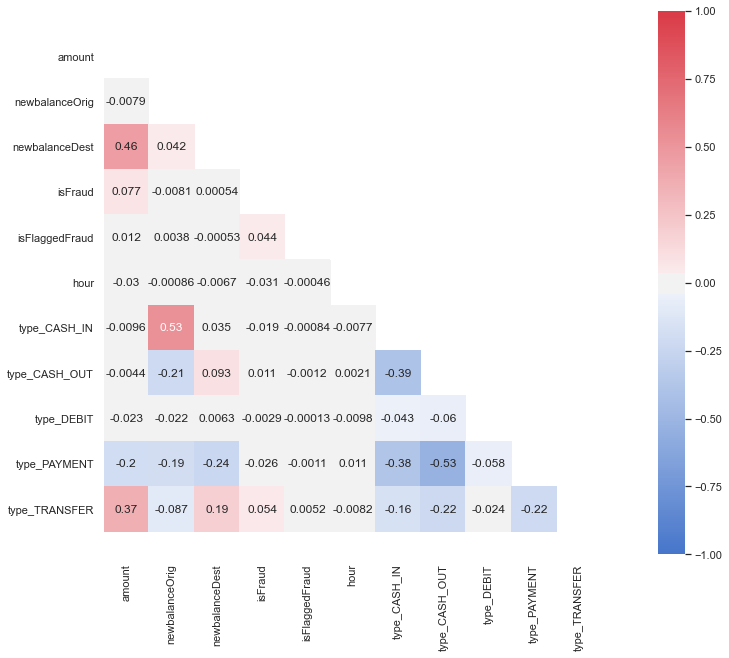

In [28]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(20,10))

# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors

# Plot the heatmap
sns.heatmap(data.corr(), mask=mask, annot=True, square=True, cmap=cmap , vmin=-1, vmax=1, ax=ax)  

# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

### Run a logisitc regression classifier and evaluate its accuracy.

### LOGREG w/ UNBALACED DATASET

In [29]:
# Your code here
# Splitting the data between X_train, X_test, y_train, y_test 

X = data.drop(columns = 'isFraud')
y = data['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=True)

In [30]:
logreg = LogisticRegression().fit(X_train, y_train)
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

Training set accuracy: 0.998
Test set accuracy: 0.998


### LOGREG w/ UNDERSAMPLING 

In [31]:
from imblearn.under_sampling import RandomUnderSampler

Using TensorFlow backend.


In [32]:
random_under_sampler = RandomUnderSampler(random_state=42)
X_train, y_train = random_under_sampler.fit_sample(X_train, y_train)

In [33]:
logreg = LogisticRegression().fit(X_train, y_train)
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

Training set accuracy: 0.681
Test set accuracy: 0.460


### Now pick a model of your choice and evaluate its accuracy.

In [34]:
# Your code here

def baseline_report(model, X_train, y_train, name):
    strat_k_fold = StratifiedKFold(n_splits=2, shuffle=True)
    model.fit(X_train, y_train)
    print(name)
    accuracy     = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='accuracy'))
    print(accuracy)
    precision    = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='precision'))
    print(precision)
#    recall       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='recall'))
#    print(recall)
    f1score      = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='f1'))
    print(f1score)
    #rocauc       = np.mean(cross_val_score(model, X_train, y_train, cv=strat_k_fold, scoring='roc_auc'))


    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
#                             'recall'       : [recall],
                             'f1score'      : [f1score],
#                             'rocauc'       : [rocauc],
                            })
    return df_model

In [39]:
models = {  'knn': KNeighborsClassifier(),
            'decisiontree': DecisionTreeClassifier(),
            'randomforest': RandomForestClassifier(),
         }

In [40]:
models_df = pd.concat([baseline_report(model, X_train, y_train, name) for (name, model) in models.items()])

knn
0.8161686637342636
0.8230552881476019
0.8139840466826468
decisiontree
0.8989079326558471
0.8981881703188015
0.8974750803580591
randomforest
0.915971484908236
0.9350410561470336
0.9136050512663891


### Which model worked better and how do you know?

### Evaluating RandomForrest with TEST data

In [41]:
for name, model in models.items():
    print(name)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

knn
              precision    recall  f1-score   support

           0       1.00      0.83      0.91   1270904
           1       0.01      0.80      0.01      1620

    accuracy                           0.83   1272524
   macro avg       0.50      0.81      0.46   1272524
weighted avg       1.00      0.83      0.90   1272524

decisiontree
              precision    recall  f1-score   support

           0       1.00      0.90      0.95   1270904
           1       0.01      0.90      0.02      1620

    accuracy                           0.90   1272524
   macro avg       0.51      0.90      0.48   1272524
weighted avg       1.00      0.90      0.94   1272524

randomforest
              precision    recall  f1-score   support

           0       1.00      0.93      0.96   1270904
           1       0.02      0.89      0.03      1620

    accuracy                           0.93   1272524
   macro avg       0.51      0.91      0.50   1272524
weighted avg       1.00      0.93      0.96 

In [42]:
# Your response here
# By looking and comparing all the indicators, the model that worked best was RandomForrest predicting Fraud cases